<a href="https://colab.research.google.com/github/Ekliipce/Machine-Learning-for-Biomedical/blob/pre-processing/eeg/EEG_and_alcohol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Electroencephalogram (EEG) and alcohol


## **EEG**
#### **What is EEG ?**
An electroencephalogram (EEG) is a test that records the brain's electrical activity noninvasively through electrodes placed on the scalp. The procedure involves placing these electrodes that are connected by wires to a computer, which then records and analyzes the electrical impulses in the brain. EEG is used for diagnosing and managing brain-related disorders like epilepsy, monitoring brain activity during surgeries, and conducting neuroscience research.

EEG patterns, consisting of different waves, are analyzed to understand normal or abnormal brain function. The procedure is safe, though preparation is required, and it might be slightly uncomfortable. EEG primarily detects activity in the brain's cortex with limited spatial resolution and can be affected by various factors like age and medication. Unlike MRI and CT scans that visualize brain structure, EEG captures real-time activity, making it a valuable tool in neuroscience and medicine.
<br><br>
#### **What does an EEG help diagnose?**

EEG is used primarily to diagnose conditions that affect brain activity. It’s particularly useful in identifying epilepsy and other seizure disorders by capturing the electrical activity of the brain. Besides, EEG can also help diagnose or manage other conditions like sleep disorders, depth of anesthesia, coma, encephalopathies, brain death, and certain psychiatric disorders. It is often used in conjunction with other diagnostic tools to provide comprehensive insights into brain health and function.
<br><br>

#### **What factors can influence the results of an EEG?**

Various factors can influence EEG results. Medications (such as sedatives, anti-epileptic drugs) can alter electrical activity in the brain, affecting the test's findings. The patient's age and overall brain development can also play a role in the results. The physical and mental state of the patient during the test, like being stressed, relaxed, asleep, or awake, can also influence the brain's electrical activity. External interference from electronic devices and not following preparatory instructions (like washing hair to ensure good electrode contact) can also impact the data quality and test outcomes.
<br><br>
#### **How reliable is EEG in diagnosing various brain disorders?**

EEG is a reliable tool for diagnosing disorders related to abnormal brain activity, like epilepsy. However, its reliability can be influenced by the technician's skill, the patient's cooperation, and the above-mentioned factors that might affect the results. While EEG provides valuable real-time data on brain function, it might not catch intermittent or infrequent abnormalities in brain activity if they don't occur during the test. Therefore, it's often used alongside other diagnostic methods, like MRI or CT scans, to provide a more complete picture of brain health and accurate diagnosis.


## **Brain and Alcohol**
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6668890/ searched deeper for Alcoholism and Human Electrophysiology.

Interestingly, the article suggests that the observed electrical abnormalities in the brains of alcoholics might not be a result of alcohol consumption per se, but rather a pre-existing condition, possibly serving as a risk marker for alcoholism. Some of these electrical characteristics, such as increased resting beta power and decreased active theta oscillations during cognitive tasks, have also been identified in individuals at high risk for developing alcoholism, even before any exposure to alcohol. Therefore, the text proposes that an inherent imbalance in CNS excitation and inhibition might predispose individuals to alcoholism. This imbalance is suggested to not only contribute to the risk of developing alcoholism but might also offer insights into the neurobiology of craving and relapse in alcoholism

## I/ Get the Dataset

In [1]:
!wget https://archive.ics.uci.edu/static/public/121/eeg+database.zip
!unzip -qq eeg+database.zip
!tar -xf SMNI_CMI_TEST.tar.gz
!tar -xf SMNI_CMI_TRAIN.tar.gz
!gunzip -k SMNI_CMI_*/*/*.gz
!rm SMNI_CMI_*/*/*.gz
!mkdir train
!mkdir test

--2023-10-08 12:15:16--  https://archive.ics.uci.edu/static/public/121/eeg+database.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘eeg+database.zip’

eeg+database.zip        [   <=>              ] 762.44M  27.2MB/s    in 29s     

2023-10-08 12:15:46 (26.2 MB/s) - ‘eeg+database.zip’ saved [799481741]



In [2]:
!pip -q install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 44.7 MB/s eta 0:00:00


In [3]:
import numpy as np

import mne
import os

from tqdm import tqdm

import pandas as pd
import re

In [5]:
file = '/content/SMNI_CMI_TRAIN/co2a0000364/co2a0000364.rd.000'


def extract_raw_data(file):
  with open(file) as f:
    lines = f.readlines()

    data = []
    channel_names = []
    is_Alcolic = lines[0][5] == 'a'
    id_patient = int(lines[0][6:13])
    trial = int(lines[4].split()[-1])

    for line in lines[4:]:
      line_split = line.split()

      if (not line.startswith('#')):
        values = line_split[-1]
        data.append(values)
      else :
        ch_name = line_split[1]
        channel_names.append(ch_name)

    data = np.array(data, dtype="float").reshape((64, -1))
    info = {"his_id" : id_patient, 'id': id_patient, "is_Alcolic" : is_Alcolic, "trial": trial}
    return data, channel_names, info

In [6]:
def save_raw_files(file, save=False, train=True):
  file_name = file.split("/")[-1].replace(".", "_") + "_eeg"

  data, ch_names, info_patient = extract_raw_data(file)
  info = mne.create_info(ch_names=ch_names, sfreq=256, ch_types='eeg')
  raw = mne.io.RawArray(data, info, verbose=False)
  raw.info['subject_info'] = info_patient

  if (save):
    dir = "train" if train else "test"
    raw.save(f"{dir}/{file_name}.fif", overwrite=True, verbose=False)
  return raw



In [6]:
for dir_name, subdirs, files in tqdm(list(os.walk('/content/'))):
    for file_name in files:
      if ((".rd.") in file_name):
        current_file = os.path.join(dir_name, file_name)
        train = "TRAIN" in current_file
        save_raw_files(current_file, save=True, train=train)


100%|██████████| 51/51 [01:11<00:00,  1.40s/it]


## Pre-processing

Create two directroies which which will contain data as csv.

In [193]:
! [ -e train_csv ] || mkdir train_csv
! [ -e test_csv ] || mkdir test_csv

Generate a dataframe from an eeg file.

In [195]:

def generate_df(file,save=False,train=True,verbose=False,frequency = 256):
  df = pd.DataFrame()
  data, channel_names, info = extract_raw_data(file)
  file_name = file.split("/")[-1]
  for time_series,channel in zip(data, channel_names):
    time = np.arange(0,time_series.shape[-1])*1/time_series.shape[-1]
    cur_df = pd.DataFrame({'value':time_series,'channel':channel,**info,'time':time})
    if(df is None):
      df = cur_df
    else:
      df = pd.concat([df,cur_df],ignore_index=True)
  if(save):
    dir = "train" if train else "test"
    saving_path = f'{dir}_csv/{file_name}.csv'
    df.to_csv(saving_path)
  return df



In [198]:
df = generate_df('/content/SMNI_CMI_TRAIN/co2c0000338/co2c0000338.rd.014')
df.head()

,value,channel,his_id,is_Alcolic,id,trial,time
0,8.525,FP1,338,False,338,0,0.000000
1,9.501,FP1,338,False,338,0,0.003906
2,8.525,FP1,338,False,338,0,0.007812
3,7.548,FP1,338,False,338,0,0.011719
4,7.060,FP1,338,False,338,0,0.015625


<Axes: xlabel='time'>

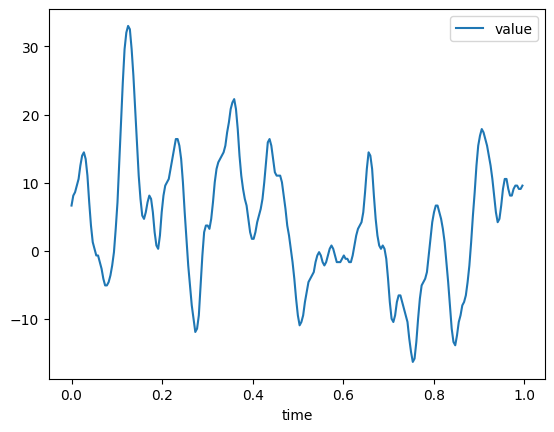

In [202]:
df[df['channel'] == 'Y'].plot(x='time',y='value')

In [7]:
def generated_csv(content_dir:str='/content/',train=True):
  for dir_name, subdirs, files in tqdm(list(os.walk(content_dir))):

    for file_name in (files):
      current_file = os.path.join(dir_name, file_name)
      regex = r'.+\.rd\.\d+$'

      if (re.match(regex,file_name)):
        generate_df(current_file,save=True,train=train)


100%|██████████| 21/21 [02:00<00:00,  5.75s/it]


In [170]:
for data_dir,train in zip(['SMNI_CMI_TRAIN','SMNI_CMI_TEST'],[True,False]):
  generated_csv(data_dir,train)

alcoholic.gif	    eeg.data.html  eeg.html	  SMNI_CMI_TEST.tar.gz	 test
control.gif	    eeg_full	   output.txt	  SMNI_CMI_TRAIN	 train
eeg+database.zip    eeg.full.html  sample_data	  SMNI_CMI_TRAIN.tar.gz
eeg+database.zip.1  eeg_full.tar   SMNI_CMI_TEST  smni_eeg_data.tar.gz
